In [1]:
import numpy as np
from scipy.signal import butter, filtfilt, welch
from scipy.fft import fft
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from utils.visualize import *
from utils.signal_process import *
%matplotlib inline

import os

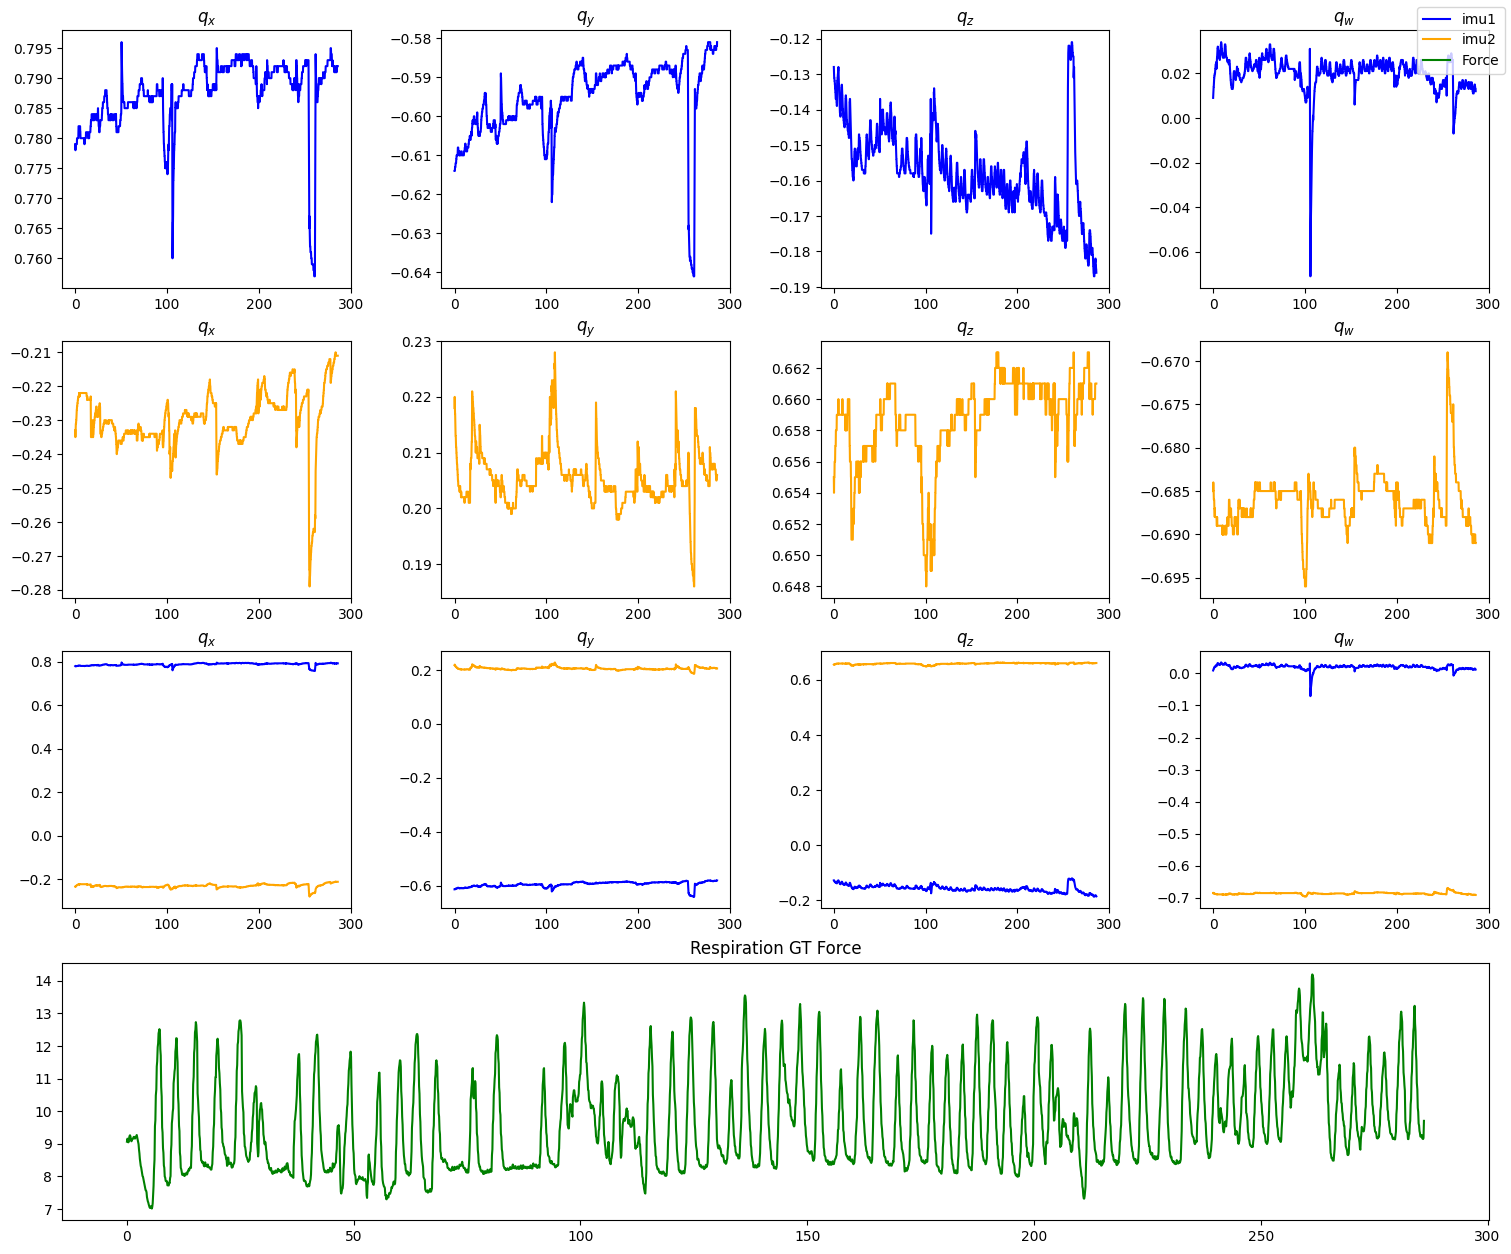

In [2]:
fs = 10
start_pt, end_pt = 0, -1
still_pt = 300 # 500

# action_name = "stand_3" # sit_1, stand_1, walk_stand_1, run_stand_1
# file_path = f"./data/2P/train/{action_name}.csv"

action_name = "stand_0407_0808" # sit_0407_0746, sit_0407_0751, stand_0407_0808, walk_stand_0407_0852
file_path = f"./data/2P/test/{action_name}.csv"

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data = data.iloc[start_pt:end_pt]

data = align_delay(data, delay=10)
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

draw_imu_curve(data, overlap=True, show_gt=True)

In [ ]:
# Quaternion operations
# q: (qx, qy, qz, qw)
def quaternion_inverse(q):
    """Returns the inverse of a quaternion."""
    # q_conj = q * np.array([1, -1, -1, -1])
    q_conj = q * np.array([-1, -1, -1, 1])
    return q_conj / np.dot(q, q)

def quaternion_multiply(q1, q2):
    """Multiplies two quaternions."""
    # w1, x1, y1, z1 = q1
    # w2, x2, y2, z2 = q2
    x1, y1, z1, w1 = q1
    x2, y2, z2, w2 = q2

    # return np.array([
    #     w1*w2 - x1*x2 - y1*y2 - z1*z2,
    #     w1*x2 + x1*w2 + y1*z2 - z1*y2,
    #     w1*y2 - x1*z2 + y1*w2 + z1*x2,
    #     w1*z2 + x1*y2 - y1*x2 + z1*w2
    # ])
    
    return np.array([
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2,
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
    ])

# qv: (sample_num, 4)
def calculate_theta(qv, qd):
    """Calculate relative angle theta from two quaternions."""
    qr = np.array([quaternion_multiply(qv[i], quaternion_inverse(qd[i])) for i in range(len(qv))])
    # wr = qr[:, 0]
    wr = qr[:, 3]
    theta = 2 * np.arccos(np.clip(wr, -1.0, 1.0))
    return theta

def bandpass_filter(signal, fs=10, lowcut=0.1, highcut=1.5, order=4):
    """Apply a Butterworth bandpass filter."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def estimate_rr_gt(theta, force, fs=10, window_size=256, stride=64, pad_mul=8):
    """Estimate respiratory rate using PSD."""
    pred_ls = []
    gt_ls = []
    t_ls = []
    for start in range(0, len(theta) - window_size + 1, stride):
        window = theta[start:start + window_size]
        window_force = force[start:start + window_size]

        # gt
        gt, t = compute_gt(window_force, nperseg=window_size, noverlap=0, start_t=start, return_t=True)

        # pred
        window = bandpass_filter(window)
        window = window - np.mean(window)
        window = np.pad(window, (0, window_size * (pad_mul-1)), 'constant', constant_values=(0, 0))
        # f, Pxx = welch(window, fs=fs, nperseg=window_size)
        f, Pxx = welch(window, fs=fs, nperseg=len(window))
        # print(window[:10])
        # print(f.shape)
        # print(f)
        
        # Limit to respiratory range
        idx = np.where((f >= 0.1) & (f <= 1.0)) # idx = np.where((f >= 0.1) & (f <= 1.5))
        f = f[idx]
        Pxx = Pxx[idx]

        peak_freq = f[np.argmax(Pxx)]
        rr_bpm = peak_freq * 60  # Convert Hz to breaths per minute

        pred_ls.append(rr_bpm)
        gt_ls.append(gt)
        t_ls.append(t)
        
        # break
    return np.stack(pred_ls, axis=0), np.stack(gt_ls, axis=0).reshape(-1), np.stack(t_ls, axis=0)

def evaluate_paper_file(Q_1, Q_2, force, action_name=None, fs=10, window_size=256, stride=64, pad_mul=8, visualize=True, show_error=True):
    theta_ls = calculate_theta(Q_1, Q_2)
    pred, gt, times = estimate_rr_gt(theta_ls, force, window_size=window_size, stride=stride, pad_mul=pad_mul)
    gt = gt * 60

    preds = {"paper_5": pred}

    if visualize:
        draw_learning_results(preds, gt, times, action_name)

    if show_error:
        print(f"Evaluation Results - MSE Loss: {mean_squared_error(gt, pred):.4f}, L1 Loss: {mean_absolute_error(gt, pred):.4f} 1/min, R\u00b2:{r2_score(gt, pred):.4f}")

    return pred, gt, times

def evaluate_paper_action(dir, visualize=True, fs=10, window_size=256, stride=64, pad_mul=8):
    method = "paper_5"
    pred_test = {method:{}}
    gt_test = {}
    mae_test = {method:{}} # overall mae in each [method][action]
    relative_mae = {method:{}} # each sample point relative mae in [method][action]

    # all sample points
    pred_ls = []
    gt_ls = []

    # iterate all files
    for file in os.listdir(dir):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"): 
            print(os.path.join(dir, filename))
            action_name = filename.split("_")[0]
            
            # load data
            data = pd.read_csv(os.path.join(dir, filename))
            data.columns = [
                "Timestamp",
                "imu1_q_x",
                "imu1_q_y",
                "imu1_q_z",
                "imu1_q_w",
                "imu2_q_x",
                "imu2_q_y",
                "imu2_q_z",
                "imu2_q_w",
                "Force",
                "RR",
            ]

            data = data.iloc[start_pt:end_pt]

            # align delay
            data = align_delay(data, delay=10) # sp.align_delay(data, delay=10)
            data["Timestamp"] = pd.to_datetime(data["Timestamp"])
            data = data.set_index("Timestamp")

            # predict rr
            target, ref = 'imu1', 'imu2'
            Q_1 = data[[target + '_q_x', target + '_q_y', target + '_q_z', target + '_q_w']].to_numpy()
            Q_2 = data[[ref + '_q_x', ref + '_q_y', ref + '_q_z', ref + '_q_w']].to_numpy()
            force = data["Force"].to_numpy()
            pred, gt, times = evaluate_paper_file(Q_1, Q_2, force, window_size=window_size, stride=stride, pad_mul=pad_mul, action_name=action_name, visualize=False)

            # calculate error
            if action_name in pred_test[method]:
                pred_test[method][action_name].extend(list(pred))
                gt_test[action_name].extend(list(gt))
                relative_mae[method][action_name].extend(list(abs(pred - gt) / gt * 100))
            else:
                # print(pred.shape)
                # print(list(pred))
                # print(gt.shape)
                # print(abs(pred - gt) / gt * 100)
                pred_test[method][action_name] = list(pred)
                gt_test[action_name] = list(gt)
                relative_mae[method][action_name] = list(abs(pred - gt) / gt * 100)

            pred_ls.extend(list(pred))
            gt_ls.extend(list(gt))

    action_ls = pred_test[next(iter(pred_test))].keys()
    mae_test[method] = {key:{} for key in action_ls}
    print(f"\n{method}")
    for action_name in action_ls:
        # print(action_name)
        mae_test[method][action_name] = mean_absolute_error(gt_test[action_name], pred_test[method][action_name])
        avg_l1_loss = mae_test[method][action_name]
        # print(relative_mae[method][action_name])
        avg_relative_mae = np.mean(relative_mae[method][action_name])
        # print(avg_l1_loss)
        # print(avg_relative_mae)
        print(f"{action_name} - L1 Loss: {avg_l1_loss:.4f} 1/min, E%: {avg_relative_mae:.4f}%")
    
    overall_relative_mae = np.mean((abs(np.array(pred_ls) - np.array(gt_ls)) / np.array(gt_ls) * 100))
    print(f"\nOverall - L1 Loss: {mean_absolute_error(gt_ls, pred_ls):.4f} 1/min, E%: {overall_relative_mae:.4f}%")
    
    if visualize:
        draw_learning_results_action(pred_test, gt_test, mae_test, models_name=[method], paper=True)
        draw_learning_results_action_relative(relative_mae, sigma_num=1, models_name=[method])

./data/2P/test\sit_0407_0746.csv
Evaluation Results - MSE Loss: 52.9009, L1 Loss: 5.6469 1/min, R²:-44.3121
./data/2P/test\sit_0407_0751.csv
Evaluation Results - MSE Loss: 25.1314, L1 Loss: 4.0357 1/min, R²:-7.7240
./data/2P/test\sit_0407_0803.csv
Evaluation Results - MSE Loss: 8.4317, L1 Loss: 1.7519 1/min, R²:-0.3272
./data/2P/test\stand_0407_0808.csv
Evaluation Results - MSE Loss: 25.1163, L1 Loss: 4.0028 1/min, R²:-3.8469
./data/2P/test\stand_0407_0816.csv
Evaluation Results - MSE Loss: 57.1591, L1 Loss: 6.5764 1/min, R²:-46.1400
./data/2P/test\stand_0407_0822.csv
Evaluation Results - MSE Loss: 17.0397, L1 Loss: 3.0061 1/min, R²:-5.6852
./data/2P/test\walk_stand_0407_0852.csv
Evaluation Results - MSE Loss: 179.6682, L1 Loss: 12.5702 1/min, R²:-28.1472
./data/2P/test\walk_stand_0407_0858.csv
Evaluation Results - MSE Loss: 139.4836, L1 Loss: 11.2002 1/min, R²:-32.0521
./data/2P/test\walk_stand_0407_0903.csv
Evaluation Results - MSE Loss: 173.8192, L1 Loss: 12.4680 1/min, R²:-40.0406


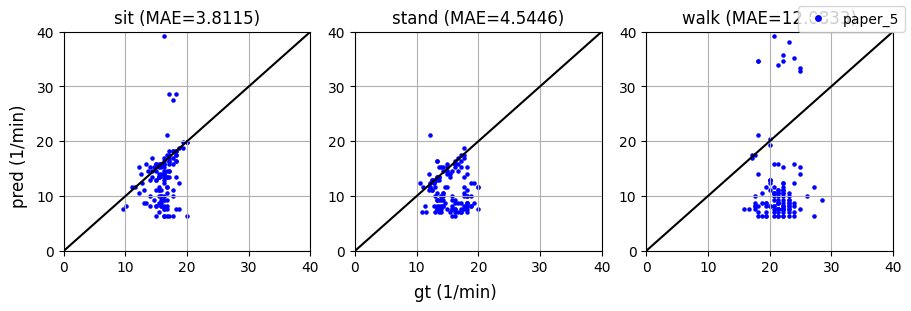

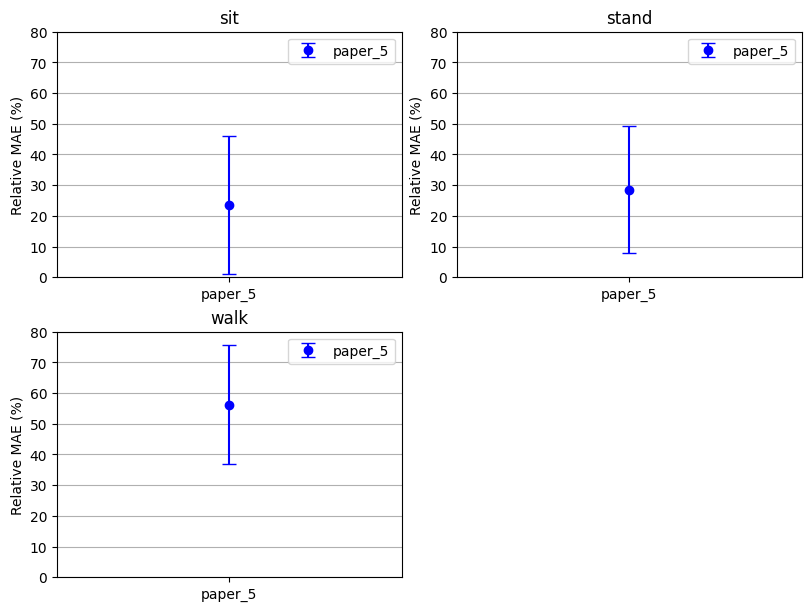

In [8]:
# parameters
window_size=256
stride=64
pad_mul=4

evaluate_paper_action("./data/2P/test", visualize=True, window_size=window_size, stride=stride, pad_mul=pad_mul)

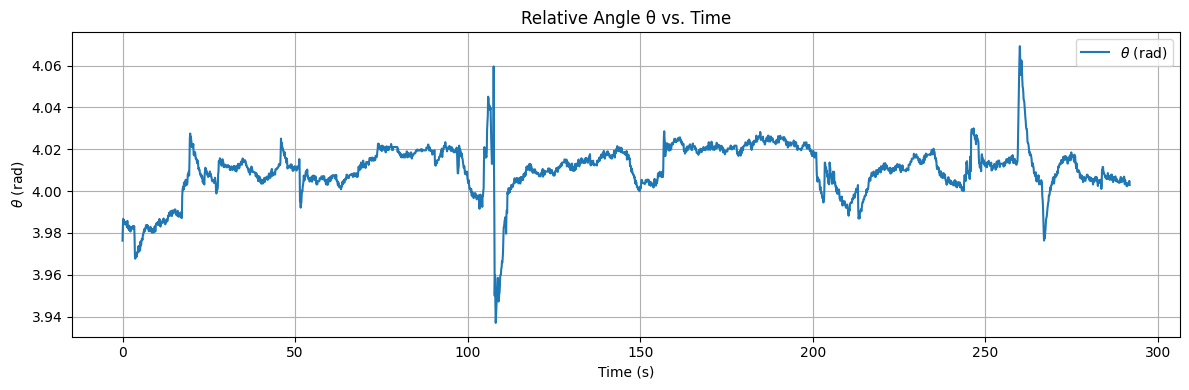

In [ ]:
window_size=256
stride=64

target, ref = 'imu1', 'imu2'
Q_1 = data[[target + '_q_x', target + '_q_y', target + '_q_z', target + '_q_w']].to_numpy()
Q_2 = data[[ref + '_q_x', ref + '_q_y', ref + '_q_z', ref + '_q_w']].to_numpy()

theta_ls = calculate_theta(Q_1, Q_2)
t = np.linspace(0, len(theta_ls) / fs, len(theta_ls))

# Plot theta vs. time
plt.figure(figsize=(12, 4))
plt.plot(t, theta_ls, label=r'$\theta$ (rad)')
plt.xlabel('Time (s)')
plt.ylabel(r'$\theta$ (rad)')
plt.title('Relative Angle θ vs. Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

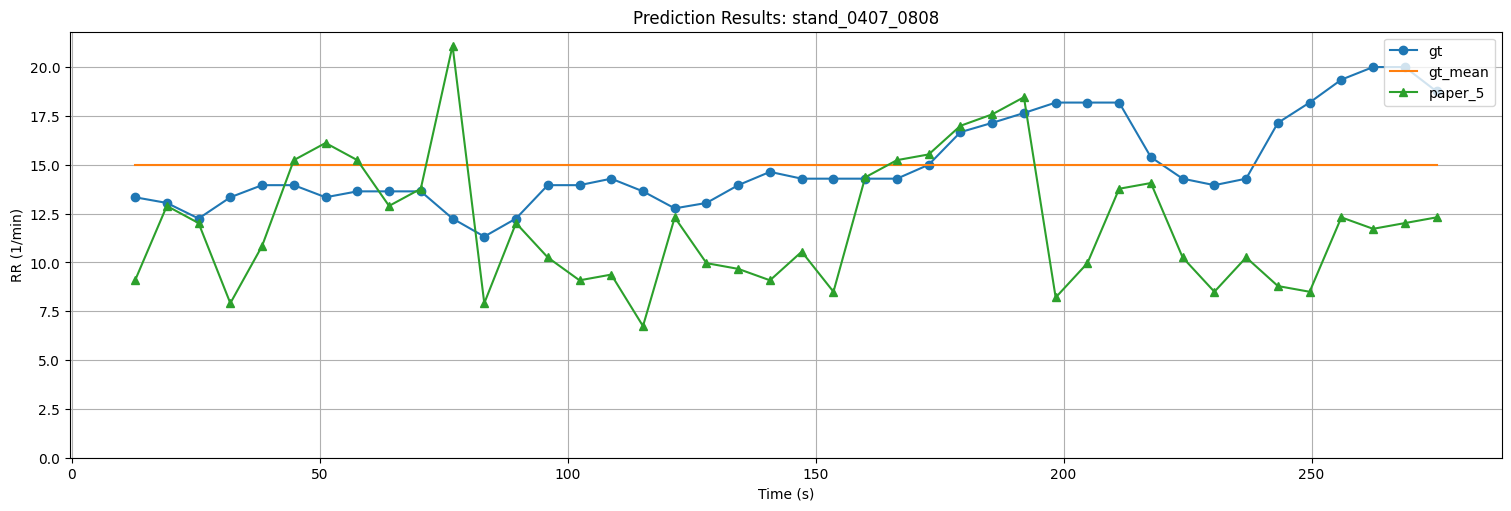

Evaluation Results - MSE Loss: 24.1739, L1 Loss: 3.9017 1/min, R²:-3.6651


In [ ]:
# parameters
window_size=256
stride=64
pad_mul=8

target, ref = 'imu1', 'imu2'
Q_1 = data[[target + '_q_x', target + '_q_y', target + '_q_z', target + '_q_w']].to_numpy()
Q_2 = data[[ref + '_q_x', ref + '_q_y', ref + '_q_z', ref + '_q_w']].to_numpy()
force = data["Force"].to_numpy()

evaluate_paper_file(Q_1, Q_2, force, window_size=window_size, stride=stride, pad_mul=pad_mul, action_name=action_name)

In [99]:
q1 = np.array([[0, 0, 0, 1]]) # euler:(0, 0, 0)
q2 = np.array([[0.0000, 0.7071, 0.0000, 0.7071]]) # euler:(0, 90, 0)
q3 = np.array([[-0.5000, 0.5000, 0.5000, 0.5000]]) # euler:(0, 90, 90)
q4 = np.array([[0.7071, 0.0000, -0.7071, 0.0000]]) # euler:(180, 90, 0)

print(calculate_theta(q1, q2) * 180 / np.pi)
print(calculate_theta(q2, q3) * 180 / np.pi)
print(calculate_theta(q2, q4) * 180 / np.pi)

[89.99890105]
[90.00109893]
[180.]
